# MMTMTONN

C:\Users\user\AppData\Local\Temp\ipykernel_5556\3955317500.py:34: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config;


2400
0
epoch 0, J 45.5976244746, vf 0.5159, ch 0.0744
1
2
3
4
5
6
7
8
9
10
epoch 10, J 14.0139859160, vf 0.6976, ch 0.0631
11
12
13
14
15
16
17
18
19
20
epoch 20, J 25.6880301350, vf 0.5361, ch 0.0947
21
22
23
24
25
26
27
28
29
30
epoch 30, J 18.3939754391, vf 0.4867, ch 0.1612
31
32
33
34
35
36
37
38
39
40
epoch 40, J 15.4284139519, vf 0.4345, ch 0.3546
41
42
43
44
45
46
47
48
49
50
epoch 50, J 15.1725881765, vf 0.4255, ch 0.2640
51
52
53
54
55
56
57
58
59
60
epoch 60, J 15.3073252443, vf 0.4142, ch 0.2934
61
62
63
64
65
66
67
68
69
70
epoch 70, J 15.1659785409, vf 0.4142, ch 0.0554
71
72
73
74
75
76
77
78
79
80
epoch 80, J 15.1865474768, vf 0.4120, ch 0.0758
81
82
83
84
85
86
87
88
89
90
epoch 90, J 15.1742057806, vf 0.4123, ch 0.0334
91
92
93
94
95
96
97
98
99
100
epoch 100, J 15.1935577072, vf 0.4112, ch 0.0322
101
102
103
104
105
106
107
108
109
110
epoch 110, J 15.2091150381, vf 0.4107, ch 0.0152
111
112
113
114
115
116
117
118
119
120
epoch 120, J 15.2234538439, vf 0.4102, ch 0.

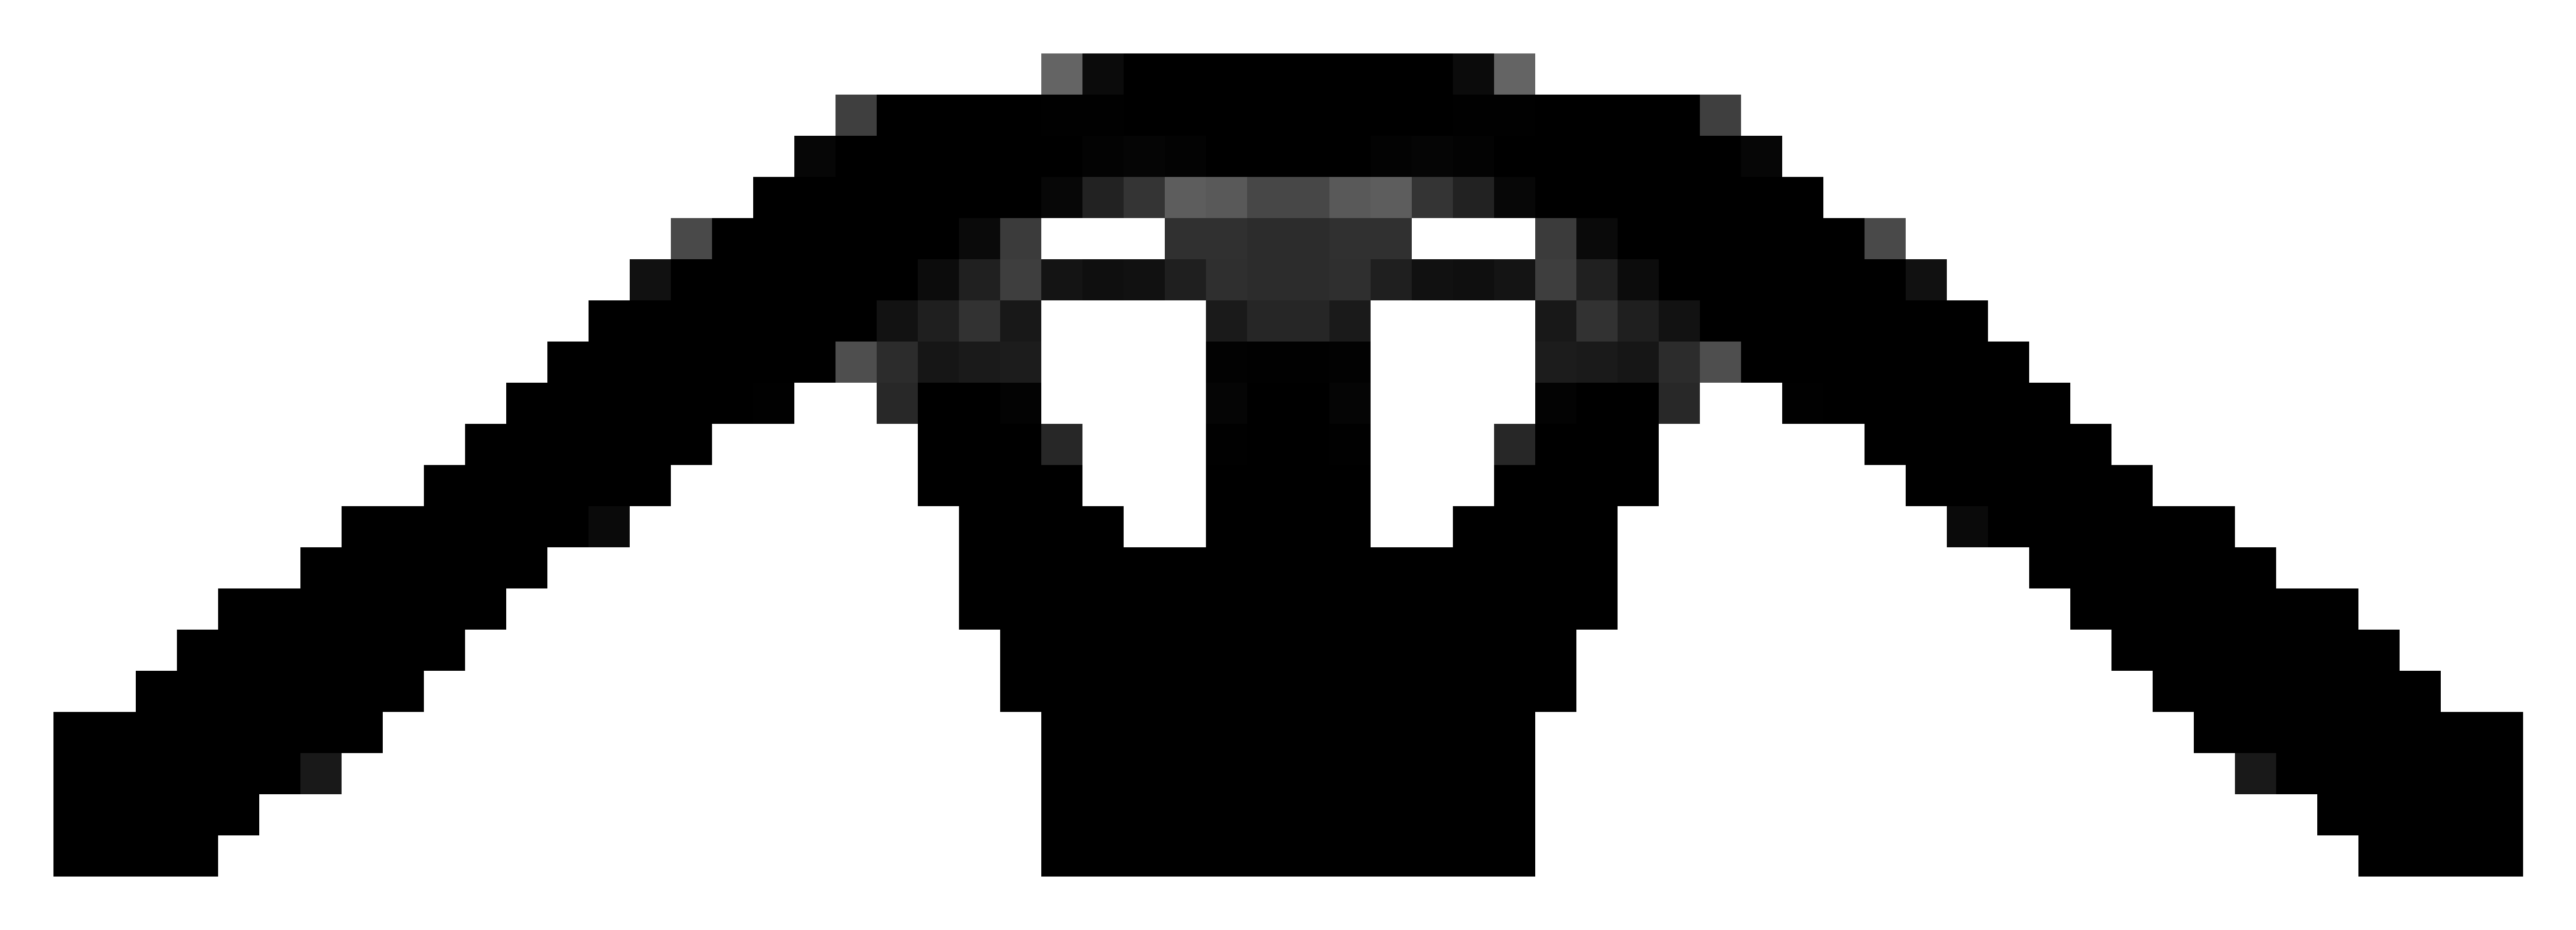



*****High Resolution result of minimum compliance*****




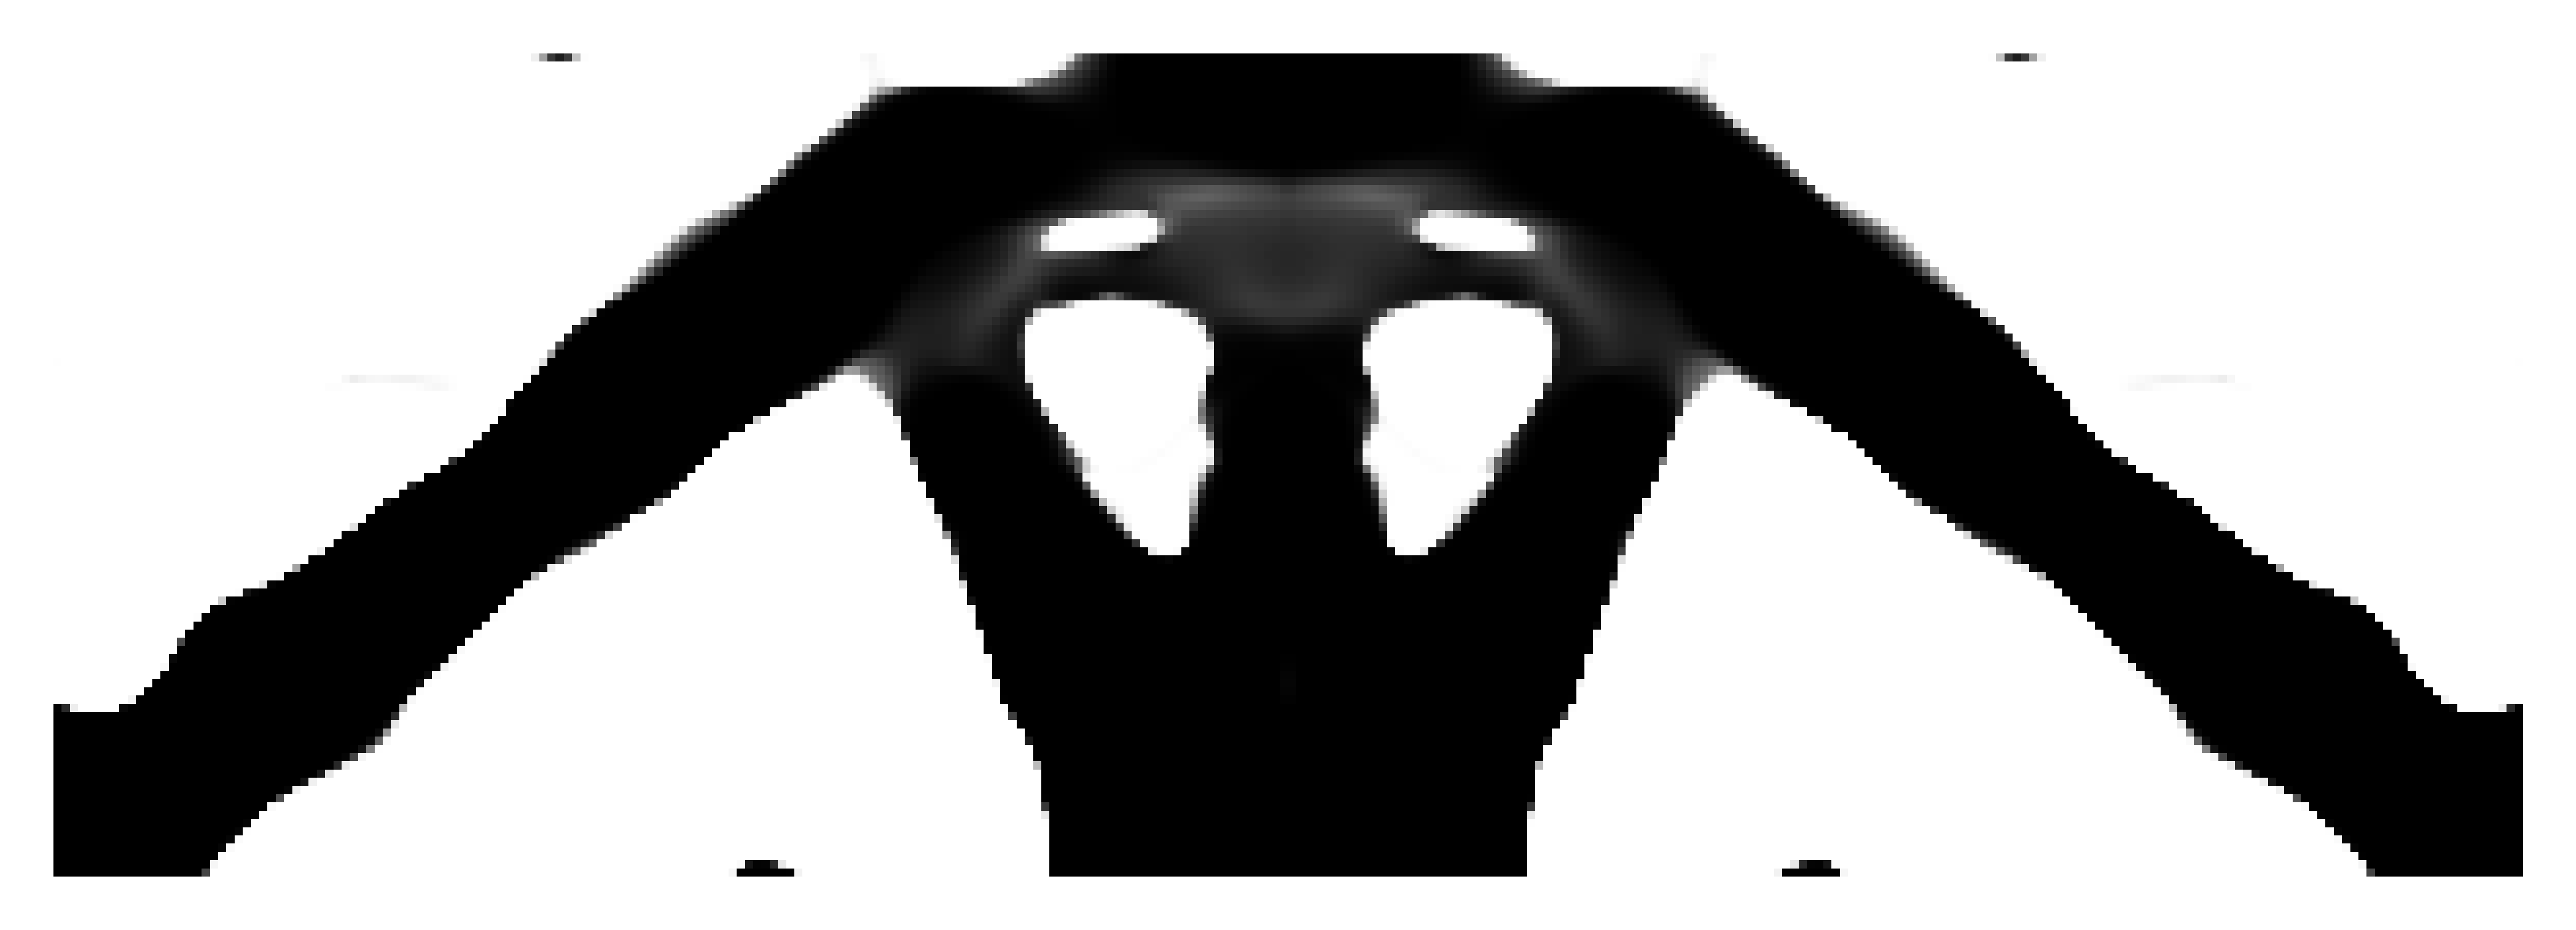

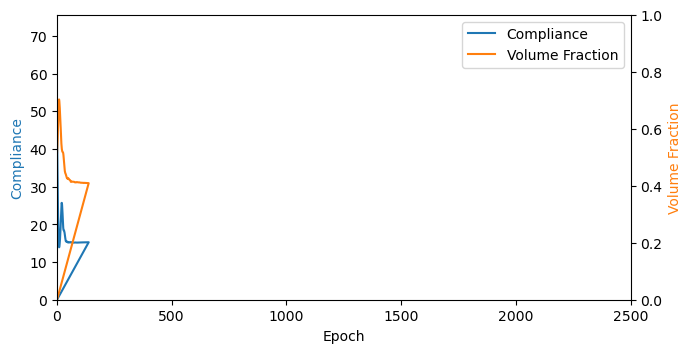

Total Execution time:  51.398597955703735  s ... ... ...


In [4]:

# -*- coding: utf-8 -*-
"""
# Multiaterials topology optimization using deep neural network for coupled thermoechanical problems
# Authors : Md. Imrul Reza Shishir, Alireza Tabarraei
# Affliation : Multiscale Material Modelding Labratory, Department of Mechanical Engineering and Engineering Science, The University of North Carolina at Charlotte, Charlotte, NC 28223, USA
# Corresponding Author : atabarra@uncc.edu , mshishir@uncc.edu (imrul.reza.shishir@gmail.com)
# Submitted to Computers & Structures Volume 291, 15 January 2024, 107218
# Received 25 March 2023, Accepted 29 October 2023, Available online 16 November 2023
# For academic purposes only

@author: imrul

"""

# We begin by importing the necessary libraries
import time
start_x = time.time()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

# import resource
# import rsrc

import jax
import jax.numpy as jnp
from jax import jit, grad, random, jacfwd, value_and_grad
from jax.example_libraries import stax, optimizers
from functools import partial
from jax.config import config; 
import jax.profiler

from network import TopNet

config.update("jax_enable_x64", True)

np.random.seed(0) 
rand_key = random.PRNGKey(0); # reproducibility

nelx, nely = 60, 20;
res = 1 ;
elemSize = np.array([1., 1.])
mesh = {'ndim':2, 'nelx':nelx, 'nely':nely, 'elemSize':elemSize, 'ndof8':2*(nelx+1)*(nely+1), 'ndof4':(nelx+1)*(nely+1), 'numElems':nelx*nely, 'res': res};

# observe that xyElems is an array from jax. 
# This makes tracking the variable possible
xyElems = jnp.array(generatePointsInsideDomain(mesh));
print(xyElems.size)

edofMat4x, edofMat4y, edofMat4, edofMat8, iK4x, jK4x , iK4y, jK4y , iK4, jK4 , iK8, jK8 = getMeshStructure(mesh);
B = getBMatrix(mesh, 0., 0.); # eval B matrix at elem center

"""### Material"""

#Next we define the relevant material property. 
# We are concerned only with structural mech
# at the moment. penal here refers to the SIMP penalization constant
material = {'Emax':1., 'Emin':1e-3, 'nu':0.3, 'penal':3., 'k' : 1., 'alpha_th': 5e-4};

material['KEm'], material['KEth'], material['CEthm'] = getD0(material);

"""### BC"""

#  ~~~~~~~~~~~~ Setup ~~~~~~~~~~~~~#
# Chose mechanical loading condition
# BothSide Fixed Beam 'ThermoMecha' [example = 1] 
### load orientation..... Single central and half at both quater [load_orien = 0], Single central load [load_orien = 1], distributed load [load_orien = 2]
# Cantiliver Beam 'TipCantilever' [example = 0] 

example = 1; # see below for description
load_orien = 1; # 
#  ~~~~~~~~~~~~Other Simulation Parameters~~~~~~~~~~~~~#
Tref = 0 # Reference Temperature
Tsink = 0 # Sink Temperature
q = 3 # Heat flux 

# BC's and support
force = 1
exampleName = ['TipCantilever', 'ThermoMecha'][int(example)];

if (exampleName == 'TipCantilever'):
  symXAxis = False;
  symYAxis = False;
elif (exampleName == 'ThermoMecha'):
  symXAxis = False;
  symYAxis = True;

topth, bottomth, leftth, rightth, alldofsth, freedofsth, fixeddofsth, alldofsm, freedofsm, fixeddofsm = BndrNode(exampleName);

bc = {'load_orien':load_orien,'exampleName':exampleName, 'force':force, 'topth':topth,'bottomth':bottomth,'leftth':leftth,'rightth':rightth, 'alldofsth':alldofsth,'fixeddofsth':fixeddofsth,'freedofsth':freedofsth, 'alldofsm':alldofsm,'fixeddofsm':fixeddofsm,'freedofsm':freedofsm,'symXAxis':symXAxis, 'symYAxis':symYAxis, 'Tref':Tref, 'Tsink':Tsink, 'q':q};

"""### Symmetry

The resulting structure might be symmetric about an axis. However, owing to the nonlinearity of the NN this may not be enforced implicitly. We therefore explicitly enforce symmetry by transforming the coordinates

"""

# transform the coordinates of the elem centres based on if symm is enforced by the prob.
xyElems = imposeSymmetry(xyElems, mesh, bc);

"""### FE Solver CM

We now turn our attention to defining functions that are needed for solving the system. We use jit to speed up the computation

### Neural Network

# Opt

### Projections

Input and output projections help us define among many geometric, manufacturing constraints.

### Optimization
Finally, we are now ready to express the optimization problem
"""

nnspec = {'outputDim':1, 'numNeuronsPerLayer':10,  'numLayers':5};

# Optimization params
lossMethod = {'type':'penalty', 'alpha0':0.05, 'delAlpha':0.05};
#lossMethod = {'type':'logBarrier', 't0':3, 'mu':1.1};

minRadiusFn = 3.5 # lambda x, y: 20. + 0.*x
maxRadiusFn = 50 # lambda x, y: 50. + 0.*x
fourierMap = {'isOn': True, 'minRadiusFn':minRadiusFn, \
              'maxRadiusFn':maxRadiusFn, 'numTerms':200};

fourierMap['map'] = computeFourierMap(mesh, fourierMap)


optimizationParams = {'maxEpochs':2501, 'learningRate':0.01, 'desiredVolumeFraction':0.4,\
                     'lossMethod':lossMethod}

"""# Run"""
start_opt = time.time()

density, nnwts, History_J = optimizeDesign(xyElems, optimizationParams, mesh, material, bc, fourierMap, nnspec)

print("Total Design Optimization Execution time: ", time.time()-start_opt, " s ... ... ...")

print("\n\n*****Final result of minimum compliance*****\n\n");
status = 'epoch {:.2F}, J {:.10F}, vf {:.4F}, ch {:.4F}'.format(History_J[(optimizationParams['maxEpochs']-1),0], History_J[(optimizationParams['maxEpochs']-1),1], History_J[(optimizationParams['maxEpochs']-1),2], History_J[(optimizationParams['maxEpochs']-1),3]);
print(status);
plt.figure(figsize=(6, 2), dpi=1000);
plt.imshow(-density.reshape((mesh['nelx'], mesh['nely'])).T,\
          cmap='gray')
plt.axis('off')
plt.savefig("Graph_final_MinCom.png", format="PNG",bbox_inches='tight')
plt.show();

topNet = TopNet(nnspec)
res = 5;
xy = jnp.array(generatePointsInsideDomain(mesh, res));
xy = imposeSymmetry(xy, mesh, bc);
if(fourierMap['isOn']):
  xy = applyFourierMap(xy, fourierMap)
density_highres = topNet.forward(nnwts, xy);

print("\n\n*****High Resolution result of minimum compliance*****\n\n");
plt.figure(figsize=(6, 2), dpi=1000);
plt.imshow(-density_highres.reshape((mesh['nelx']*res, mesh['nely']*res)).T,\
          cmap='gray')
plt.axis('off')
plt.savefig("High_Resolution_result_Graph_final_MinCom.png", format="PNG",bbox_inches='tight')
plt.show();

plt.figure(figsize=(7.4,3.7));
host = host_subplot(111)
par1 = host.twinx()

host.set_xlim(0, (optimizationParams['maxEpochs']-1))
host.set_ylim(0, np.max(History_J[:,1])+30)
par1.set_ylim(0, 1.0)

host.set_xlabel("Epoch")
host.set_ylabel("Compliance")
par1.set_ylabel("Volume Fraction")

p1, = host.plot(History_J[:,0],History_J[:,1], label="Compliance")
p2, = par1.plot(History_J[:,0],History_J[:,2], label="Volume Fraction")

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())

plt.draw()
plt.savefig("Final_Comp_VS_Eposch.png", format="PNG")
plt.show()

print("Total Execution time: ", time.time()-start_x, " s ... ... ...")

In [ ]:
class FESolver:
  def __init__(self, mesh, material, bc):
    self.mesh = mesh;
    self.bc = bc;
    self.material = material;
    self.objectiveHandle = jit(self.objective)
  #-----------------------# 
  def objective(self, rho):
    @jit
    def youngsModulus(rho):
      Y = self.material['Emin'] + (self.material['Emax']-self.material['Emin'])*(rho+0.001)**self.material['penal'];
      # Y =(rho)**self.material['penal']
      return Y;

    '''
    #-----------------------#
    @jit
    # Code snippet 2.8
    def youngsModulus(rho): # RAMP
        S = 3. # RAMP param
        Y = 0.001*self.material['Emax'] + self.material['Emax']*(rho/ (1.+S*(1.-rho)) )
        return Y
    '''

    #----------------------------------------------------------------------------------------------#
    #-----------------------#
    @jit
    def assembleKthx(Y):
      K = jnp.zeros((self.mesh['ndof4'], self.mesh['ndof4']),dtype=float);
      kflat_t = (self.material['KEth'].flatten()[np.newaxis]).T 
      sK = (kflat_t*Y).T.flatten();
      K = K.at[iK4x, jK4x].add(sK);
      # K = jax.ops.index_add(K, idx4x, sK);
      return K;

    #-----------------------#
    @jit
    def assembleKthy(Y):
      K = jnp.zeros((self.mesh['ndof4'], self.mesh['ndof4']),dtype=float);
      kflat_t = (self.material['KEth'].flatten()[np.newaxis]).T 
      sK = (kflat_t*Y).T.flatten();
      K = K = K.at[iK4y, jK4y].add(sK); 
      # K = jax.ops.index_add(K, idx4y, sK);
      return K;

    #-----------------------#  
    @jit
    def ForceFth(Kth):
      # Apply BC for Thermal Boundary
      Fth = jnp.zeros(self.mesh['ndof4'],dtype=float)
      
      # Bondary conditions
      if (self.bc['exampleName']== 'TipCantilever'): # tip cantilever
        Fth = Fth.at[self.bc['leftth']].set(self.bc['q'])
        Fth = Fth.at[self.bc['rightth']].set(self.bc['Tsink'])
        Fth = Fth.at[self.bc['topth']].set(self.bc['Tsink'])
        Fth = Fth.at[self.bc['bottomth']].set(self.bc['Tsink'])

        Kth = Kth.at[self.bc['bottomth'],:].set(0)
        Kth = Kth.at[self.bc['bottomth'],self.bc['bottomth']].set(1)  

      elif (self.bc['exampleName']== 'ThermoMecha'):
        Fth = Fth.at[self.bc['leftth']].set(0)
        Fth = Fth.at[self.bc['rightth']].set(0)
        Fth = Fth.at[self.bc['topth']].set(self.bc['q'])
        Fth = Fth.at[self.bc['bottomth']].set(self.bc['Tsink'])

        Kth = Kth.at[self.bc['bottomth'],:].set(0)
        Kth = Kth.at[self.bc['bottomth'],self.bc['bottomth']].set(1)  
      return Kth, Fth;

    #-----------------------#
    @jit
    def solveUth(Kth,Fth):
      # Solve thermal Temperature field
      Uth = jnp.zeros(self.mesh['ndof4'],dtype=float)
      Uth = jax.scipy.linalg.solve(Kth, Fth);
      return Uth;

    #----------------------------------------------------------------------------------------------#
    #-----------------------#
    @jit
    def assembleKm(Y):
      K = jnp.zeros((self.mesh['ndof8'], self.mesh['ndof8']),dtype=float);
      kflat_t = (self.material['KEm'].flatten()[np.newaxis]).T 
      sK = (kflat_t*Y).T.flatten();
      K = K = K.at[iK8, jK8].add(sK); 
      # K = jax.ops.index_add(K, idx8, sK);
      return K;

    #-----------------------#
    @jit
    def ForceFm(Uth,Y):
      #-----------------------#
      # Define fixed external load in the mechanical load vector
      Fp = jnp.zeros(self.mesh['ndof8'],dtype=float)

      # Mechanical Bondary conditions
      if (self.bc['exampleName'] == 'TipCantilever'): # tip cantilever
        if (self.bc['load_orien'] == 0):
          if (self.mesh['nely']+1) % 2 == 0:
            Fp = Fp.at[(2*(self.mesh['nely']+1)*(self.mesh['nelx'])+self.mesh['nely']-1).astype(int)].set(-self.bc['force']/2)
            Fp = Fp.at[(2*(self.mesh['nely']+1)*(self.mesh['nelx'])+self.mesh['nely']+1).astype(int)].set(-self.bc['force']/2)
          else:
            Fp = Fp.at[(2*(self.mesh['nely']+1)*(self.mesh['nelx'])+self.mesh['nely']-1).astype(int)].set(-self.bc['force'])
            
        elif (self.bc['load_orien'] == 1):
            Fp = Fp.at[(2*(mesh['nely']+1)*(mesh['nelx']+1)-1).astype(int)].set(-self.bc['force'])

        elif (self.bc['load_orien'] == 2):
          if (self.mesh['nelx']+1) % 2 == 0:
            Fp = Fp.at[(2*(mesh['nely']+1)*(mesh['nelx']+1)-1).astype(int)].set(-self.bc['force'])
          else:
            Fp = Fp.at[(2*(mesh['nely']+1)*(mesh['nelx']+1)-1).astype(int)].set(-self.bc['force'])

      elif (self.bc['exampleName']== 'ThermoMecha'):
        if (self.bc['load_orien'] == 0): # DEFINE MECHANICAL LOADS: force unit load at center and half load in two quater distance from end
          # DEFINE MECHANICAL LOADS: force unit load at center and half load in two quater distance from end
          if (self.mesh['nelx']+1) % 2 ==0:
              Fp = Fp.at[(self.mesh['ndof8']/2-1).astype(int)].set(-self.bc['force']/2)
              Fp = Fp.at[(self.mesh['ndof8']/2+2*(self.mesh['nely']+1)-1).astype(int)].set(-self.bc['force']/2)
              L14 = jnp.ceil((self.mesh['nelx']+1)/4)
              Fp = Fp.at[(2*(self.mesh['nely']+1)*(L14)-1).astype(int)].set(-self.bc['force']/2)
              L34 = jnp.ceil(3*self.mesh['nelx']/4)
              Fp = Fp.at[(2*(self.mesh['nely']+1)*(L34+1)-1).astype(int)].set(-self.bc['force']/2)
          else:
              Fp = Fp.at[(self.mesh['ndof8']/2+1+2*jnp.floor((self.mesh['nely']+1)/2)-1).astype(int)].set(-self.bc['force'])
              L14 = jnp.floor(self.mesh['nelx']/4)
              Fp = Fp.at[(2*(self.mesh['nely']+1)*(L14+1)-1).astype(int)].set(-self.bc['force']/2)
              L34 = jnp.ceil(3*self.mesh['nelx']/4)
              Fp = Fp.at[(2*(self.mesh['nely']+1)*(L34+1)-1).astype(int)].set(-self.bc['force']/2)

        elif (self.bc['load_orien'] == 1): # DEFINE MECHANICAL LOADS: Single central load
          # DEFINE MECHANICAL LOADS: Single central load
          if (self.mesh['nelx']+1) % 2 ==0:
              Fp = Fp.at[(2*(self.mesh['nely']+1)*(self.mesh['nelx']+1)/2-1).astype(int)].set(-self.bc['force']/2)
              Fp = Fp.at[(2*(self.mesh['nely']+1)*(self.mesh['nelx']+1)/2+2*(self.mesh['nely']+1)-1).astype(int)].set(-self.bc['force']/2)

          else:
              Fp = Fp.at[(2*(self.mesh['nely']+1)*(self.mesh['nelx']+1)/2+1+2*jnp.floor((self.mesh['nely']+1)/2)-1).astype(int)].set(-self.bc['force'])

        elif (self.bc['load_orien'] == 2): # DEFINE MECHANICAL LOADS: distributed load over the length force divided bottom node (except fixed load at both end)
          # DEFINE MECHANICAL LOADS: distributed load over the length force divided bottom node (except fixed load at both end) 
          bottomm = np.asarray(range(4*self.mesh['nely']+3,2*(self.mesh['nely']+1)*(self.mesh['nelx']+1)-2*(self.mesh['nely']+1),2*(self.mesh['nely']+1)))
          Fp = Fp.at[bottomm.astype(int)].set(-self.bc['force']*10/(self.mesh['nelx']))


      #-----------------------#
      # Define thermal expamsion effect in the mechanical load vector

      Feps = jnp.zeros(self.mesh['ndof8'],dtype=float);
      sFeps = (Y*jnp.dot(self.material['CEthm'], ((Uth[edofMat4]-Tref).T))).flatten(order='F')
      # Feps = jax.ops.index_add(Feps, jax.ops.index[edofMat8.flatten().astype(int)], sFeps);
      Feps = Feps.at[edofMat8.flatten().astype(int)].add(sFeps);


      #-----------------------#
      Fm = Fp + Feps
      return Fm, Fp, Feps;

    #-----------------------#
    @jit
    def solveUm(Km,Fm):
      # eliminate fixed dofs for solving sys of eqns
      Um_free = jax.scipy.linalg.solve(Km[self.bc['freedofsm'],:][:,self.bc['freedofsm']], Fm[self.bc['freedofsm']]);
      Um = jnp.zeros((self.mesh['ndof8']),dtype=float);
      Um = Um.at[self.bc['freedofsm']].set(Um_free.reshape(-1));
      # Um = jax.ops.index_update(Um, self.bc['freedofsm'], Um_free.reshape(-1)); # homog bc wherev fixed
      return Um;

    #----------------------------------------------------------------------------------------------#
    #-----------------------#
    #-----------------------#
    @jit
    def computeCompliance(Y,Km, Um):
      J = jnp.dot(Um.T, jnp.dot(Km,Um));
      Jx= jnp.multiply(Y, jnp.sum(jnp.multiply(jnp.dot(Um[edofMat8].reshape((self.mesh['numElems'],8)),self.material['KEm']),Um[edofMat8].reshape((self.mesh['numElems'],8)) ), axis = 1));
      return J, Jx;

    #----------------------------------------------------------------------------------------------#
    #-----------------------#
    ### Solving Global Conductivity matrix and Temperature field ###
    Ythx = jnp.ones(self.mesh['nelx'])*100;
    Kthx = assembleKthx(Ythx);
    Ythy = youngsModulus(jnp.reshape(jnp.reshape(rho,(self.mesh['nely'],self.mesh['nelx']),order="F")[1:][:],(self.mesh['nely']*self.mesh['nelx']-self.mesh['nelx']),order="F"));
    Kthy = assembleKthy(Ythy);
    Kth = Kthx + Kthy
    # Apply BC for Thermal Boundary
    Kth, Fth = ForceFth(Kth);  

    ## SolveTemperature field ###
    Uth = solveUth(Kth,Fth);

    #----------------------------------------------------------------------------------------------#
    #-----------------------#
    ### Solving Global stiffness matrix, displacement field, mechanical load vector, and thermal expansion effects ###
    Y = youngsModulus(rho.flatten(order='F'));
    Km = assembleKm(Y);
    Fm, Fp, Feps = ForceFm(Uth,Y)
    Um = solveUm(Km,Fm);

    #----------------------------------------------------------------------------------------------#
    #-----------------------#
    ### Solving adjoint vector ###
    #-----------------------#
    J, Jx = computeCompliance(Y, Km, Um);
        
    return J, Jx;


In [ ]:
# Next we populate the domain with points. 
# These points are processed by the NN
def generatePointsInsideDomain(mesh, res = 1):
  # args: Mesh is dictionary containing nelx, nely, elemSize...
  # res is the number of points per elem
  # returns an array of size (numpts X 2)
  xy = np.zeros((res*mesh['nelx']*res*mesh['nely'],2));
  ctr = 0;
  for i in range(res*mesh['nelx']):
    for j in range(res*mesh['nely']):
      xy[ctr,0] = (i + 0.5)/(res*mesh['elemSize'][0]);
      xy[ctr,1] = (j + 0.5)/(res*mesh['elemSize'][1]);
      ctr += 1;
  return xy;

# with the mesh sprecified, we can now calc 
# info wrt connectivity and node numbering
def getMeshStructure(mesh):
  # returns edofMat: array of size (numElemsX8) with 
  # the global dof of each elem
  # idx: A tuple informing the position for assembly of computed entries 
  edofMat4x=np.zeros((mesh['nelx'],4),dtype=int)
  edofMat4y=np.zeros(((mesh['nelx']*mesh['nely']-mesh['nelx']),4),dtype=int)
  edofMat4=np.zeros((mesh['nelx']*mesh['nely'],4),dtype=int)
  edofMat8=np.zeros((mesh['nelx']*mesh['nely'],8),dtype=int)
  for elx in range(mesh['nelx']):
    for ely in range(mesh['nely']):
      el = ely+elx*mesh['nely']
      n1=(mesh['nely']+1)*elx+ely
      n2=(mesh['nely']+1)*(elx+1)+ely
      edofMat4[el,:] = np.array( [n1+1, n2+1, n2, n1])
      edofMat8[el,:] = np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1]);
      if ely ==0:
        edofMat4x[elx,:] = np.array( [n1+1, n2+1, n2, n1])
      else:
        el1 = ely+elx*mesh['nely']-elx-1
        edofMat4y[el1,:] = np.array( [n1+1, n2+1, n2, n1])

  iK4x = tuple(np.kron(edofMat4x,np.ones((4,1))).flatten().astype(int))
  jK4x = tuple(np.kron(edofMat4x,np.ones((1,4))).flatten().astype(int))
  iK4y = tuple(np.kron(edofMat4y,np.ones((4,1))).flatten().astype(int))
  jK4y = tuple(np.kron(edofMat4y,np.ones((1,4))).flatten().astype(int))
  iK4 = tuple(np.kron(edofMat4,np.ones((4,1))).flatten().astype(int))
  jK4 = tuple(np.kron(edofMat4,np.ones((1,4))).flatten().astype(int))
  iK8 = tuple(np.kron(edofMat8,np.ones((8,1))).flatten().astype(int))
  jK8 = tuple(np.kron(edofMat8,np.ones((1,8))).flatten().astype(int))
  # idx4x = jax.ops.index[iK4x,jK4x]
  # idx4y = jax.ops.index[iK4y,jK4y]
  # idx4 = jax.ops.index[iK4,jK4]
  # idx8 = jax.ops.index[iK8,jK8]

  return edofMat4x, edofMat4y, edofMat4, edofMat8, iK4x, jK4x , iK4y, jK4y , iK4, jK4 , iK8, jK8;

#-----------------------#
def getBMatrix(mesh, xi, eta):
  dx, dy = mesh['elemSize'][0], mesh['elemSize'][1];
  B = np.zeros((3,8));
  r1 = np.array([(2.*(eta/4. - 1./4.))/dx, -(2.*(eta/4. - 1./4))/dx,\
                  (2.*(eta/4. + 1./4))/dx,\
                  -(2.*(eta/4. + 1./4))/dx]).reshape(-1);
  r2 = np.array([(2.*(xi/4. - 1./4))/dy, -(2.*(xi/4. + 1./4))/dy,\
                  (2.*(xi/4. + 1./4))/dy, -(2.*(xi/4. - 1./4))/dy])
  
  B = [[r1[0], 0., r1[1], 0., r1[2], 0., r1[3], 0.],\
        [0., r2[0], 0., r2[1], 0., r2[2], 0., r2[3]],\
        [r2[0], r1[0], r2[1], r1[1], r2[2], r1[2], r2[3], r1[3]]];

  return jnp.array(B);

# with the material defined, we can now calculate the base constitutive matrix
def getD0(material):
  # the base constitutive matrix assumes unit 
  #area element with E = 1. and nu prescribed.
  # the material is also assumed to be isotropic.
  # returns a matrix of size (8X8)
  E = material['Emax']
  nu = material['nu'];
  k = material['k'];
  alpha_th = material['alpha_th'];
  K=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
  KEm = E/(1-nu**2)*np.array([ [K[0], K[1], K[2], K[3], K[4], K[5], K[6], K[7]],
                              [K[1], K[0], K[7], K[6], K[5], K[4], K[3], K[2]],
                              [K[2], K[7], K[0], K[5], K[6], K[3], K[4], K[1]],
                              [K[3], K[6], K[5], K[0], K[7], K[2], K[1], K[4]],
                              [K[4], K[5], K[6], K[7], K[0], K[1], K[2], K[3]],
                              [K[5], K[4], K[3], K[2], K[1], K[0], K[7], K[6]],
                              [K[6], K[3], K[4], K[1], K[2], K[7], K[0], K[5]],
                              [K[7], K[2], K[1], K[4], K[3], K[6], K[5], K[0]] ])
  KEth = k/6*np.array([ [4, -1, -2, -1],
                        [-1, 4, -1, -2],
                        [-2, -1, 4, -1],
                        [-1, -2, -1, 4]])
  CEthm = (E*alpha_th/(12*(1-nu)))*np.array([ [-2, -2, -1, -1], 
                                          [-2, -1, -1, -2], 
                                          [2, 2, 1, 1], 
                                          [-1, -2, -2, -1], 
                                          [1, 1, 2, 2], 
                                          [1, 2, 2, 1], 
                                          [-1, -1, -2, -2], 
                                          [2, 1, 1, 2] ])

  return KEm, KEth, CEthm;

def BndrNode(exampleName):
    #  ~~~~~~~~~~~~ Examples ~~~~~~~~~~~~~#
    if(exampleName == 'TipCantilever'): # tip cantilever
        topth = np.asarray(range(0,(mesh['nely']+1)*mesh['nelx']+1,mesh['nely']+1)) 
        bottomth = np.asarray(range(mesh['nely'],(mesh['nely']+1)*(mesh['nelx']+1),mesh['nely']+1))
        leftth = np.asarray(range(0,mesh['nely']+1))
        rightth = np.asarray(range((mesh['nely']+1)*mesh['nelx'],(mesh['nely']+1)*(mesh['nelx']+1)))
        
        # Define free and fixed degrees of freedoms of thermal load
        fixeddofsth = np.unique(np.concatenate((leftth,rightth,topth,bottomth), axis=0))
        alldofsth = np.asarray(range(0,(mesh['nelx']+1)*(mesh['nely']+1)))
        freedofsth = np.setdiff1d(alldofsth,fixeddofsth)
        
        # Define free and fixed degrees of freedoms of mechanical load
        alldofsm = np.arange(2*(mesh['nelx']+1)*(mesh['nely']+1))
        fixeddofsm =   np.union1d(np.asarray(range(0,2*(mesh['nely']+1))))
        freedofsm = np.setdiff1d(alldofsm,fixeddofsm)

        
    elif(exampleName == 'ThermoMecha'): # 
        topth = np.asarray(range(0,(mesh['nely']+1)*mesh['nelx']+1,mesh['nely']+1)) 
        bottomth = np.asarray(range(mesh['nely'],(mesh['nely']+1)*(mesh['nelx']+1),mesh['nely']+1))
        leftth = np.asarray(range(0,mesh['nely']+1))
        rightth = np.asarray(range((mesh['nely']+1)*mesh['nelx'],(mesh['nely']+1)*(mesh['nelx']+1)))
        
        # Define free and fixed degrees of freedoms of thermal load
        fixeddofsth = np.unique(np.concatenate((leftth,rightth,topth,bottomth), axis=0))
        alldofsth = np.asarray(range(0,(mesh['nelx']+1)*(mesh['nely']+1)))
        freedofsth = np.setdiff1d(alldofsth,fixeddofsth)
        
        # Define free and fixed degrees of freedoms of mechanical load
        alldofsm = np.arange(2*(mesh['nelx']+1)*(mesh['nely']+1))
        fixeddofsm =   np.union1d(np.asarray(range(0,2*(mesh['nely']+1))),np.asarray(range(2*(mesh['nely']+1)*(mesh['nelx']),2*(mesh['nely']+1)*(mesh['nelx']+1))))
        freedofsm = np.setdiff1d(alldofsm,fixeddofsm)
    
    return topth, bottomth, leftth, rightth, alldofsth, freedofsth, fixeddofsth, alldofsm, freedofsm, fixeddofsm

def imposeSymmetry(xy, mesh, bc):
  if(bc['symYAxis']):
    xv = xy[:,0].at[ np.arange(len(xy[:,0])) ].set( 0.5*mesh['nelx'] + jnp.abs( xy[:,0] - 0.5*mesh['nelx']) );
    # xv = jax.ops.index_update(xy[:,0],index[:], 0.5*mesh['nelx'] + jnp.abs( xy[:,0] - 0.5*mesh['nelx']) );
  else:
    xv = xy[:,0]
  if(bc['symXAxis']):
    yv = xy[:,1].at[ np.arange(len(xy[:,1])) ].set( 0.5*mesh['nely'] + jnp.abs( xy[:,1] - 0.5*mesh['nely']) );
    # yv = jax.ops.index_update(xy[:,1],index[:], 0.5*mesh['nely'] + jnp.abs( xy[:,1] - 0.5*mesh['nely']) );
  else:
    yv = xy[:,1]
  xy = jnp.stack((xv,yv)).T;
  return xy;

In [ ]:
#-------FOURIER LENGTH SCALE-----------#
def computeFourierMap(mesh, fourierMap):
  # compute the map
  coordnMapSize = (mesh['ndim'], fourierMap['numTerms'])
  freqSign = np.random.choice([-1.,1.], coordnMapSize)
  stdUniform = np.random.uniform(0.,1., coordnMapSize) 
  wmin = 1./(2*fourierMap['maxRadiusFn'])
  wmax = 1./(2*fourierMap['minRadiusFn']) # w~1/R
  wu = wmin +  (wmax - wmin)*stdUniform
  coordnMap = np.einsum('ij,ij->ij', freqSign, wu)
  return coordnMap

#-----------------#
def applyFourierMap(xyElems, fourierMap):
  if(fourierMap['isOn']):
    c = jnp.cos(2*np.pi*jnp.einsum('ij,jk->ik', xyElems, fourierMap['map']));
    s = jnp.sin(2*np.pi*jnp.einsum('ij,jk->ik', xyElems, fourierMap['map']));
    xy = jnp.concatenate((c, s), axis = 1);
    return xy;
  else:
    return xy;

def optimizeDesign(xy, optParams, mesh, material, bc, fourierMap, nnspec):
  FE = FESolver(mesh, material, bc)
  # input projection
  if(fourierMap['isOn']):
   xy = applyFourierMap(xy, fourierMap)
  nnspec['inputDim'] =  xy.shape[1]
  topNet = TopNet(nnspec)
  # make the NN
  #   init_fn, applyNN = makeNetwork(nnspec);
  #   fwdNN = jit(lambda nnwts, x: applyNN(nnwts, x));
  #   _, params = init_fn(rand_key, (-1, xy.shape[1]));
  # optimizer
  opt_init, opt_update, get_params = optimizers.adam(optParams['learningRate']);
  opt_state = opt_init(topNet.wts);
  opt_update = jit(opt_update);
  
  # fwd once to get J0-scaling param
  density0  = topNet.forward(get_params(opt_state), xy)
  J0, Jx0 = FE.objectiveHandle(density0.reshape(-1));
  
  History_J = np.zeros((optParams['maxEpochs'],4))
  densityOld =density0;
  volchange = 1;

  # loss function
  def computeLoss(nnwts):
    density  = topNet.forward(nnwts, xy)
    volcons = (jnp.mean(density)/optParams['desiredVolumeFraction'])- 1.
    J, Jx = FE.objectiveHandle(density.reshape(-1));

    if(optParams['lossMethod']['type'] == 'penalty'):
      alpha = optParams['lossMethod']['alpha0'] + \
              epoch*optParams['lossMethod']['delAlpha']; # penalty method
      loss = Jx.sum()/Jx0.sum() + alpha*volcons**2;
    if(optParams['lossMethod']['type'] == 'logBarrier'):
      t = optParams['lossMethod']['t0']* \
                        optParams['lossMethod']['mu']**epoch;
      if(volcons < (-1/t**2)):
        psi = -jnp.log(-volcons)/t;
      else:
        psi = t*volcons - jnp.log(1/t**2)/t + 1/t;
      loss = Jx.sum()/Jx0.sum() + psi;    
    return loss;
  
  # optimization loop    

  Time_epoch = 0;

  # for epoch in range(optParams['maxEpochs']):
  epoch = 0;
  while (volchange>0.01 or epoch < 30):
    print(epoch)
    start_epoch = time.time()

    opt_state = opt_update(epoch, \
                optimizers.clip_grads(jax.grad(computeLoss)(get_params(opt_state)), 0.2),\
                opt_state)

    density = topNet.forward(get_params(opt_state), xy);

    J, Jx = FE.objectiveHandle(density.reshape(-1));

    volf= jnp.mean(density);

    volchange = jnp.amax(jnp.amax(jnp.abs(density.reshape((mesh['nelx'], mesh['nely'])).T- densityOld.reshape((mesh['nelx'], mesh['nely'])).T))); 
    densityOld =density;

    History_J[epoch,:] =[epoch, J, volf, volchange]

    if(epoch%10 == 0):
      status = 'epoch {:d}, J {:.10F}, vf {:.4F}, ch {:.4F}'.format(epoch, J, volf, volchange);
      print(status);

    epoch =epoch +1;

  print("\n\n*****Topology Optimization of minimum compliance*****\n\n");
  status = 'epoch {:d}, J {:.10F}, vf {:.4F}, ch {:.4F}'.format(epoch-1, J, volf, volchange);
  print(status);
  return density, get_params(opt_state), History_J

# Network

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec  5 13:35:33 2022

@author: imrul
"""

import numpy as np
import jax.numpy as jnp
import jax.nn as nn
from jax import jit, random
np.random.seed(0)

rand_key = random.PRNGKey(0) # reproducibility
from jax.example_libraries import stax, optimizers
#-----------------------#
def elementwise(fun, **fun_kwargs):
    """Layer that applies a scalar function elementwise on its inputs."""
    init_fun = lambda rng, input_shape: (input_shape, ())
    apply_fun = lambda params, inputs, **kwargs: fun(inputs, **fun_kwargs)
    return init_fun, apply_fun
Swish = elementwise(nn.swish)
#-----------------------#
class TopNet:
  def __init__(self, nnSettings):
    self.nnSettings = nnSettings
    init_fn, applyNN = self.makeNetwork(nnSettings)
    self.fwdNN = jit(lambda nnwts, x: applyNN(nnwts, x))
    _, self.wts = init_fn(rand_key, (-1, nnSettings['inputDim']))
  #-----------------------#
  def makeNetwork(self, nnSettings):
    # JAX network definition
    layers = []
    for i in range(nnSettings['numLayers']-1):
      layers.append(stax.Dense(nnSettings['numNeuronsPerLayer']))
      layers.append(Swish)#(stax.LeakyRelu)
    layers.append(stax.Dense(nnSettings['outputDim']))
    return stax.serial(*layers)
  #-----------------------#
  def forward(self, wts, x):
    self.wts = wts
    nnOut = self.fwdNN(wts, x)
    # mstrType = nn.softmax(nnOut[:,0:-1])
    rho = nn.sigmoid(nnOut[:,-1]).reshape(-1)
    return rho
  #-----------------------#

In [2]:
from network import TopNet

nnspec = {'outputDim':1, 'numNeuronsPerLayer':10,  'numLayers':5};
topNet = TopNet(nnspec)
topNet.summary()

KeyError: 'inputDim'